# Vehicle Routing Problems (VRP)

## Framework

The Vehicle Routing Problem (VRP) is composed of
- $n$ locations to visit,
- $K$ vehicles,
- $1$ depot.
The aim of a VRP is to **minimize the total traveling cost** in such a way that **all the $n$ locations are visited only once** by one of the $K$ vehicles, and **all the vehicles start and end their trip at the depot**.

## Model

|**Data** | |
|:---|:---|
|$i$ | Integers from $0$ to $n$ representing the nodes. |
| | The node $i = 0$ represents the depot, and the rest are demand points. |
|$c_{ij} > 0$ | The cost of travel from the node $i$ to the node $j$. |

|**Variables** | |
|:---|:---|
|$x_{ij} \in \{0,1\}$ | The decision either to travel from the node $i$ to the node $j$. |

Here we make the following interpretation on the variables $x_{ij}$:
$$
x_{ij} = 
\begin{cases}
1 & \text{if there is a travel from $i$ to $j$,} \\
0 & \text{if there is no travel from $i$ to $j$.}
\end{cases}
$$

### Objective function

The total cost of the tour is given by
$$
Z = \sum_{i = 0}^{n} \sum_{j = 0}^{n} c_{ij}x_{ij},
$$
where this cost is to be minimized.

### Constraints

- No self-visit: $$x_{ii} = 0, \qquad (\forall i = 0,\dots,n) \iff \sum_{i=0}^{n} x_{ii} = 0.$$
- Unique inbound at demand points: $$\sum_{i=1}^{n} x_{ij} = 1, \qquad (\forall j = 1,\dots,n).$$
- Unique outbound at demand points: $$\sum_{j=1}^{n} x_{ij} = 1, \qquad (\forall i = 1,\dots,n).$$
- $K$ vehicles leave the depot: $$\sum_{j=1}^{n} x_{0j} = K.$$
- $K$ vehicles enter the depot: $$\sum_{i=1}^{n} x_{i0} = K.$$

## First Example

Consider the simple case that consists of $n=5$ demand points with $K=2$ vehicles. The following table shows the traveling costs between nodes.

| Nodes | 0 | 1 | 2 | 3 | 4 | 5 |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **0** | - | 9 | 8 | 11 | 11 | 10 |
| **1** | 8 | - | 9 | 8 | 10 | 9 |
| **2** | 10 | 9 | - | 13 | 7 | 10 |
| **3** | 6 | 13 | 8 | - | 10 | 8 |
| **4** | 2 | 2 | 18 | 5 | - | 7 |
| **5** | 9 | 8 | 9 | 10 | 10 | - |

In [1]:
import numpy as np
from pyscipopt import quicksum, Model
import networkx as nx

In [2]:
c = np.array([
    [0, 9, 8, 11, 11, 10],
    [8, 0, 9, 8, 10, 9],
    [10, 9, 0, 13, 7, 10],
    [6, 13, 8, 0, 10, 8],
    [2, 2, 18, 5, 0, 7],
    [9, 8, 9, 10, 10, 0]
])
n = np.shape(c)[0]
K = 2

In [3]:
vrp = Model()

# Define x[i][j]
x = [[vrp.addVar(vtype='B') for j in range(n)] for i in range(n)]

# Define objective function
vrp.setObjective(quicksum(c[i][j]*x[i][j] for i in range(n) for j in range(n)), sense='minimize')

# Constraints
# No self-visit.
vrp.addCons(quicksum(x[i][i] for i in range(n)) == 0)
# Unique inbound at demand points.
for j in range(1,n):
    vrp.addCons(quicksum(x[i][j] for i in range(n)) == 1)
# Unique outbound at demand points.
for i in range(1,n):
    vrp.addCons(quicksum(x[i][j] for j in range(n)) == 1)
# K vehicles leave the depot.
vrp.addCons(quicksum(x[0][j] for j in range(1,n)) == K)
# K vehicles enter the depot.
vrp.addCons(quicksum(x[i][0] for i in range(1,n)) == K)

c13

In [4]:
vrp.optimize()
SOL = vrp.getBestSol()

presolving:
(round 1, fast)       6 del vars, 1 del conss, 0 add conss, 6 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 10 clqs
(round 2, exhaustive) 6 del vars, 1 del conss, 0 add conss, 6 chg bounds, 0 chg sides, 0 chg coeffs, 10 upgd conss, 0 impls, 10 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 6 deleted vars, 1 deleted constraints, 0 added constraints, 6 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 10 cliques
presolved problem has 30 variables (30 bin, 0 int, 0 impl, 0 cont) and 12 constraints
     10 constraints of type <setppc>
      2 constraints of type <linear>
transformed objective value is always integral (scale: 1)
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |

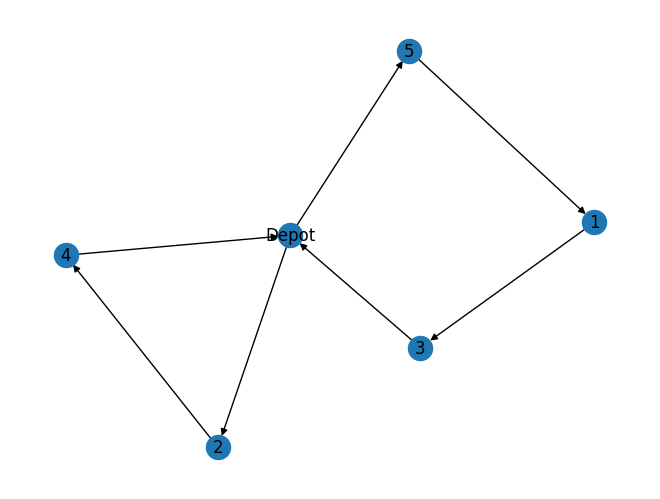

In [5]:
X = np.array([[SOL[x[i][j]] for j in range(n)] for i in range(n)])

G = nx.DiGraph(X)
labeldict = {}
labeldict[0] = "Depot"
for i in range(1,n):
    labeldict[i] = f"{i}"
nx.draw(G, labels=labeldict)

## Subtour elimination

The no-subtour constraints are not included in the formulation of VRP, due to the fact that subtours occur naturally with different vehicles.
However, there could be an unwanted subtour as we shall see in the next example.

In [6]:
c = np.array([
    [ 0,  1, 10,  1, 10, 10, 10],
    [10,  0,  1, 10, 10, 10, 10],
    [ 1, 10,  0, 10, 10, 10, 10],
    [10, 10, 10,  0,  1, 10, 10],
    [ 1, 10, 10, 10,  0, 10, 10],
    [10, 10, 10, 10, 10,  0,  1],
    [10, 10, 10, 10, 10,  1, 10]
])
n = np.shape(c)[0]
K = 2

In [7]:
vrp = Model()

# Define x[i][j]
x = [[vrp.addVar(vtype='B') for j in range(n)] for i in range(n)]

# Define objective function
vrp.setObjective(quicksum(c[i][j]*x[i][j] for i in range(n) for j in range(n)), sense='minimize')

# Constraints
# No self-visit.
vrp.addCons(quicksum(x[i][i] for i in range(n)) == 0)
# Unique inbound at demand points.
for j in range(1,n):
    vrp.addCons(quicksum(x[i][j] for i in range(n)) == 1)
# Unique outbound at demand points.
for i in range(1,n):
    vrp.addCons(quicksum(x[i][j] for j in range(n)) == 1)
# K vehicles leave the depot.
vrp.addCons(quicksum(x[0][j] for j in range(1,n)) == K)
# K vehicles enter the depot.
vrp.addCons(quicksum(x[i][0] for i in range(1,n)) == K)

c15

In [8]:
vrp.optimize()
SOL = vrp.getBestSol()

presolving:
(round 1, fast)       7 del vars, 1 del conss, 0 add conss, 7 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 12 clqs
(round 2, exhaustive) 7 del vars, 1 del conss, 0 add conss, 7 chg bounds, 0 chg sides, 0 chg coeffs, 12 upgd conss, 0 impls, 12 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) symmetry computation finished: 3 generators found (max: 1500, log10 of symmetry group size: 0.0) (symcode time: 0.00)
dynamic symmetry handling statistics:
   orbitopal reduction:       no components
   orbital reduction:          1 components of sizes 3
   lexicographic reduction:    3 permutations with support sizes 22, 36, 38
handled 1 out of 1 symmetry components
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 7 deleted vars, 1 deleted constraints, 0 added constraints, 7 tightened bounds, 0 added holes, 0 changed sides, 0 changed coeffic

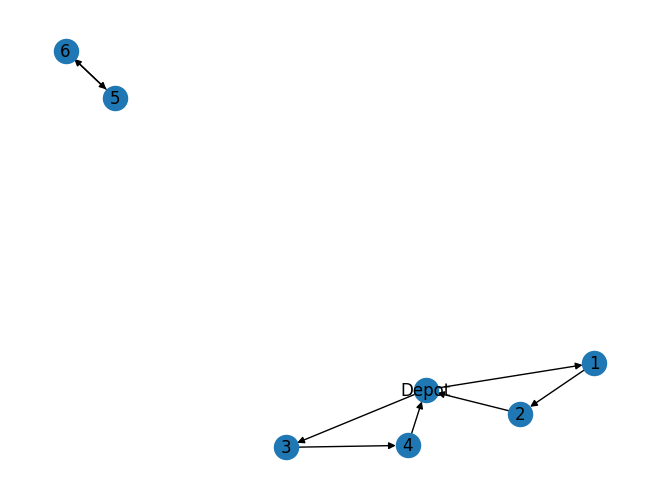

In [9]:
X = np.array([[SOL[x[i][j]] for j in range(n)] for i in range(n)])

G = nx.DiGraph(X)
labeldict = {}
labeldict[0] = "Depot"
for i in range(1,n):
    labeldict[i] = f"{i}"
nx.draw(G, labels=labeldict)

### Manually fix the unwanted subtours.
Looking at the solution of this instance, there is an unwanted subtour between nodes $5$ and $6$.
To eliminate this, we add a constraint to prevent this particular loop.

In [10]:
vrp = Model()

# Define x[i][j]
x = [[vrp.addVar(vtype='B') for j in range(n)] for i in range(n)]

# Define objective function
vrp.setObjective(quicksum(c[i][j]*x[i][j] for i in range(n) for j in range(n)), sense='minimize')

# Constraints
# No self-visit.
vrp.addCons(quicksum(x[i][i] for i in range(n)) == 0)
# Unique inbound at demand points.
for j in range(1,n):
    vrp.addCons(quicksum(x[i][j] for i in range(n)) == 1)
# Unique outbound at demand points.
for i in range(1,n):
    vrp.addCons(quicksum(x[i][j] for j in range(n)) == 1)
# K vehicles leave the depot.
vrp.addCons(quicksum(x[0][j] for j in range(1,n)) == K)
# K vehicles enter the depot.
vrp.addCons(quicksum(x[i][0] for i in range(1,n)) == K)

# One more constraint to prevent the loop between nodes 5 and 6.
vrp.addCons(x[5][6] + x[6][5] <= 2-1)

c16

presolving:
(round 1, fast)       7 del vars, 1 del conss, 0 add conss, 7 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 13 clqs
(round 2, exhaustive) 7 del vars, 1 del conss, 0 add conss, 7 chg bounds, 0 chg sides, 0 chg coeffs, 13 upgd conss, 0 impls, 13 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) symmetry computation finished: 3 generators found (max: 1500, log10 of symmetry group size: 0.0) (symcode time: 0.00)
dynamic symmetry handling statistics:
   orbitopal reduction:       no components
   orbital reduction:          1 components of sizes 3
   lexicographic reduction:    3 permutations with support sizes 22, 36, 38
handled 1 out of 1 symmetry components
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 7 deleted vars, 1 deleted constraints, 0 added constraints, 7 tightened bounds, 0 added holes, 0 changed sides, 0 changed coeffic

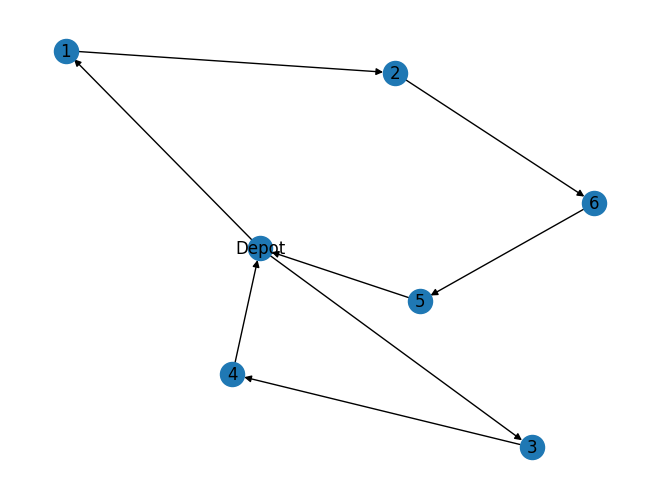

In [11]:
vrp.optimize()
SOL = vrp.getBestSol()

X = np.array([[SOL[x[i][j]] for j in range(n)] for i in range(n)])

G = nx.DiGraph(X)
labeldict = {}
labeldict[0] = "Depot"
for i in range(1,n):
    labeldict[i] = f"{i}"
nx.draw(G, labels=labeldict)

------